In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import joblib

In [2]:
# Load your datasets
weekly_data = pd.read_csv('/home/mfholth/subseasonal/weekly_data/CONUS_Regions_1980_to_2020.csv')  
inputs = pd.read_csv('/home/mfholth/subseasonal/weekly_data/time_inputs_1980_to_2020.csv')  

In [3]:
weekly_data.tail()

,Date,W,W_Zscore,SW,SW_Zscore,MW,MW_Zscore,SE,SE_Zscore,NE,NE_Zscore
2127,202048,274.928241,0.313781,281.625883,0.132580,277.426647,0.628623,284.893028,0.499934,278.132074,1.427501
2128,202049,276.280747,0.919912,280.196149,-0.209015,276.857347,0.923294,279.956116,-0.527396,272.812944,0.264258
2129,202050,272.946853,-0.068846,280.450409,0.244725,275.514340,0.639229,283.028246,0.670363,273.382723,0.803760
2130,202051,275.432352,1.097018,280.557403,0.630007,275.538160,0.899829,279.404231,-0.228720,268.156655,-0.360961
2131,202052,272.434482,0.307299,280.304300,0.770289,272.621528,0.211097,280.248162,0.111760,272.491536,0.930872


In [3]:
# Ensure 'date' is treated as a string for alignment
weekly_data['Date'] = weekly_data['Date'].astype(str)
inputs['Date'] = inputs['Date'].astype(str)

In [5]:
inputs.head()

,Date,Week,10yr_cos,10yr_sin,5yr_cos,5yr_sin,2yr_cos,2yr_sin,1yr_cos,1yr_sin,0.5yr_cos,0.5yr_sin,0.25yr_cos,0.25yr_sin
0,198001,1,0.999927,0.012083,0.999708,0.024164,0.998176,0.060378,0.992709,0.120537,0.970942,0.239316,0.885456,0.464723
1,198002,2,0.999708,0.024164,0.998832,0.048313,0.992709,0.120537,0.970942,0.239316,0.885456,0.464723,0.568065,0.822984
2,198003,3,0.999343,0.036241,0.997373,0.072435,0.983620,0.180255,0.935016,0.354605,0.748511,0.663123,0.120537,0.992709
3,198004,4,0.998832,0.048313,0.995332,0.096514,0.970942,0.239316,0.885456,0.464723,0.568065,0.822984,-0.354605,0.935016
4,198005,5,0.998176,0.060378,0.992709,0.120537,0.954721,0.297503,0.822984,0.568065,0.354605,0.935016,-0.748511,0.663123


In [4]:
# Merge datasets on the 'date' column
data = pd.merge(weekly_data, inputs, on='Date')

# Set 'date' as index
data.set_index('Date', inplace=True)

# Define training and testing split
train_data = data.loc[data.index.str[:4].astype(int) <= 2016]
test_data = data.loc[data.index.str[:4].astype(int) > 2016]

In [5]:
test_data.head()

,W,W_Zscore,SW,SW_Zscore,MW,MW_Zscore,SE,SE_Zscore,NE,NE_Zscore,...,5yr_cos,5yr_sin,2yr_cos,2yr_sin,1yr_cos,1yr_sin,0.5yr_cos,0.5yr_sin,0.25yr_cos,0.25yr_sin
Date,,,,,,,,,,,,,,,,,,,,,
201701,266.418800,-1.960233,277.838763,-0.294113,263.624729,-0.838629,280.659262,0.341741,269.462497,0.386647,...,-0.822984,0.568065,-0.998176,-0.060378,0.992709,0.120537,0.970942,0.239316,0.885456,0.464723
201702,270.932644,-0.626313,282.574674,1.324866,265.450421,-0.453997,281.179070,0.536375,268.382833,0.242166,...,-0.836470,0.548013,-0.992709,-0.120537,0.970942,0.239316,0.885456,0.464723,0.568065,0.822984
201703,271.962824,-0.273148,281.135018,0.649477,273.152746,1.510492,287.098424,2.310073,271.956937,1.260776,...,-0.849468,0.527640,-0.983620,-0.180255,0.935016,0.354605,0.748511,0.663123,0.120537,0.992709
201704,269.794296,-1.387273,278.500196,-0.775446,272.088188,1.162374,282.762115,1.214489,272.953156,1.510287,...,-0.861970,0.506960,-0.970942,-0.239316,0.885456,0.464723,0.568065,0.822984,-0.354605,0.935016
201705,273.052644,0.122127,282.034473,0.827405,268.845958,0.247871,280.979220,0.312048,267.439383,-0.032677,...,-0.873968,0.485983,-0.954721,-0.297503,0.822984,0.568065,0.354605,0.935016,-0.748511,0.663123


In [8]:
time_vars = [col for col in train_data.columns if col not in ['W' ,'SW', 'MW', 'SE' ,'NE', 'W_Zscore',\
                                                              'SW_Zscore','MW_Zscore','SE_Zscore','NE_Zscore',]]
time_vars

['Week',
 '10yr_cos',
 '10yr_sin',
 '5yr_cos',
 '5yr_sin',
 '2yr_cos',
 '2yr_sin',
 '1yr_cos',
 '1yr_sin',
 '0.5yr_cos',
 '0.5yr_sin',
 '0.25yr_cos',
 '0.25yr_sin']

Run one linear model per region, predict onto test set and print results 
Run this first, as these models will be used for the next analysis

In [12]:
# run this first! 
results={}
for region in regions:
    # Extract inputs (X) and targets (y)
    X_train = train_data[time_vars]
    y_train = train_data[region]
    X_test = test_data[time_vars]
    y_test = test_data[region]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)

    # Test the model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Save results
    results[region] = {'rmse': rmse, 'model': model}

    print(f"Region: {region}, RMSE: {rmse:.4f}")

# Results now contain the MSE for each region

Region: W, RMSE: 2.2593
Region: SW, RMSE: 1.8535
Region: MW, RMSE: 2.9841
Region: SE, RMSE: 2.4427
Region: NE, RMSE: 2.6950


Use fitted models to predict onto test set and plot results on test set with last 2 
years of training data

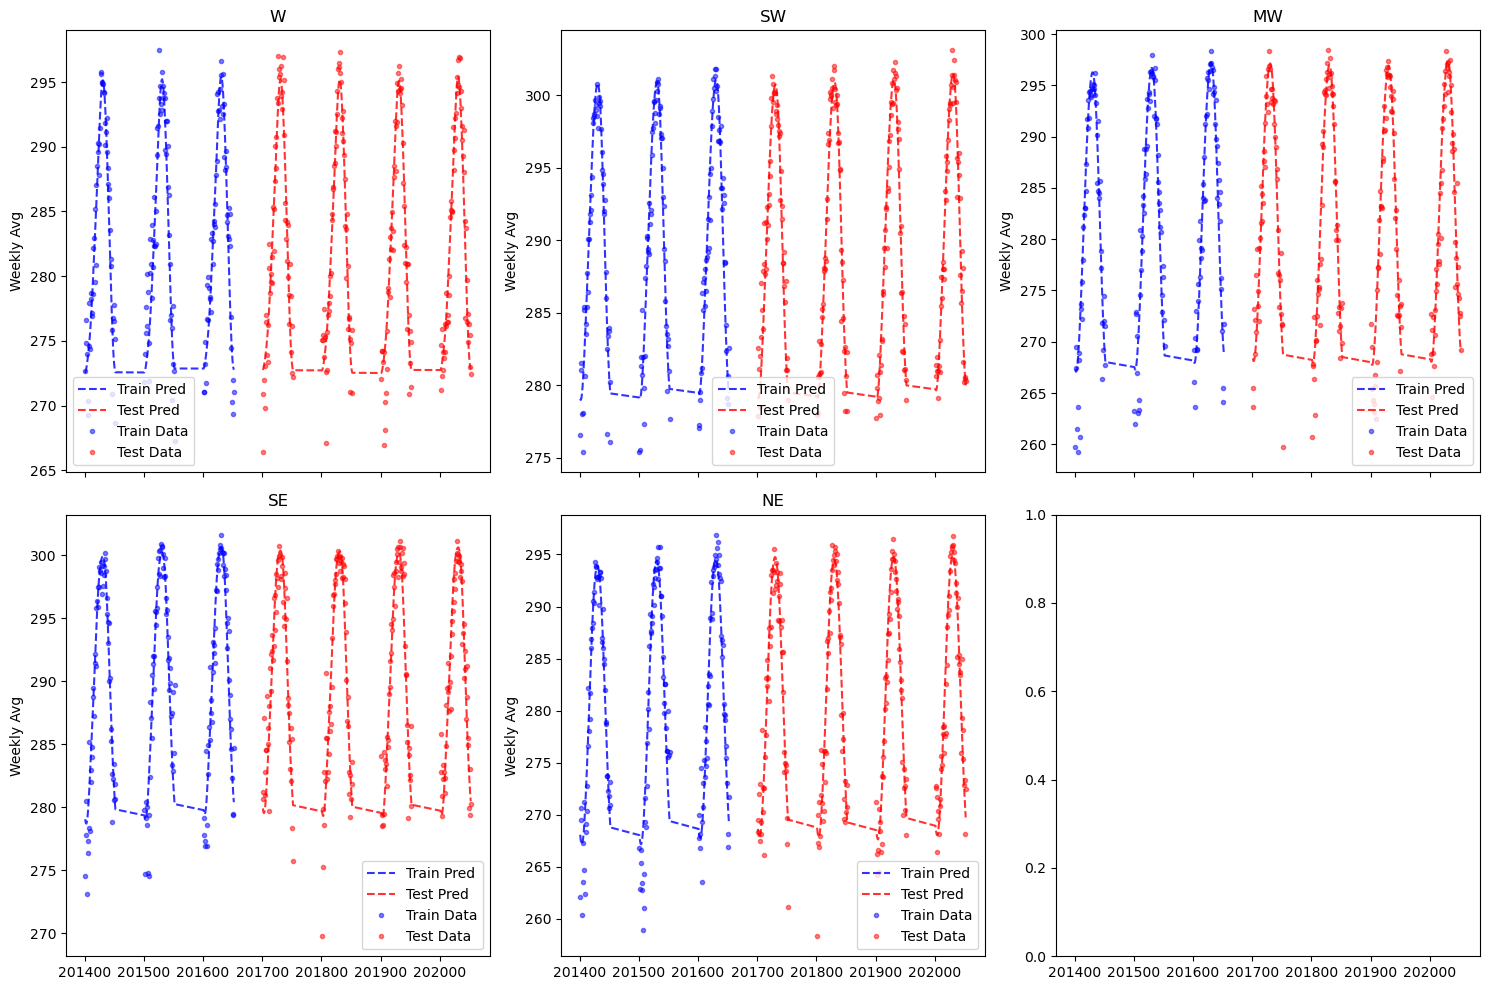

In [13]:
# carry out model fitting, prediction on test set
regions = ['W', 'SW', 'MW', 'SE', 'NE'] 
# Define number of rows and columns for subplots
num_regions = len(regions)
num_cols = min(3, num_regions)  # Up to 3 columns
num_rows = (num_regions + num_cols - 1) // num_cols  # Calculate rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True)
axes = np.array(axes).reshape(-1)  # Flatten axes in case of 1D array

# Define last two years of training data
last_train_year = 2014  # Last two years of training: 2013-2014
train_filter = train_data.index.str[:4].astype(int) >= last_train_year

# Loop through each region to plot
for i, region in enumerate(regions):
    ax = axes[i]

    # Extract subset of training data (last two years)
    X_train = train_data.loc[train_filter, time_vars]
    y_train = train_data.loc[train_filter, region]

    # Extract full test data
    X_test = test_data[time_vars]
    y_test = test_data[region]

    # Predictions
    model = results[region]['model']
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results[region] = {
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

    # Convert index to numeric time representation & ensure sorting
    train_dates = X_train.index.astype(int).sort_values()
    test_dates = X_test.index.astype(int).sort_values()

    # Plot predictions **first** to avoid overlap issues
    ax.plot(train_dates, y_train_pred, 'b--', label='Train Pred', alpha=0.8, zorder=1)
    ax.plot(test_dates, y_test_pred, 'r--', label='Test Pred', alpha=0.8, zorder=1)

    # Plot actual data **on top** with markers for better clarity
    ax.plot(train_dates, y_train, 'bo', label='Train Data', alpha=0.5, markersize=3, zorder=2)
    ax.plot(test_dates, y_test, 'ro', label='Test Data', alpha=0.5, markersize=3, zorder=2)

    ax.set_title(region)
    ax.set_ylabel('Weekly Avg')
    ax.legend()

# Adjust layout
fig.tight_layout()
plt.show()

In [14]:
# Carry out model fitting, save residuals, extreme RMSEs/residuals, plots
# Define the regions and their corresponding Z-score column names
# W	SW	MW	SE	NE
regions = ['W', 'SW', 'MW', 'SE', 'NE']  # Update if there are more
region_zscores = [f"{region}_Zscore" for region in regions]

# Dictionary to store models and errors
results = {}

# Create a directory to store plots
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Loop through each region
for region, zscore_col in zip(regions, region_zscores):
    print(f"Processing region: {region}")

    # Define predictors and target
    X_train = train_data[time_vars]
    y_train = train_data[region]
    X_test = test_data[time_vars]
    y_test = test_data[region]

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute RMSE for test set
    rmse_all = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Compute RMSE for "extremes" (Z-score < -1 or Z-score > 1)
    extreme_mask = (test_data[zscore_col] < -1) | (test_data[zscore_col] > 1)
    if extreme_mask.sum() > 0:  # Avoid errors if no extremes exist
        rmse_extreme = np.sqrt(mean_squared_error(y_test[extreme_mask], y_test_pred[extreme_mask]))
    else:
        rmse_extreme = np.nan  # Assign NaN if no extremes exist

    # Store model and errors
    results[region] = {
        'model': model,
        'rmse_all': rmse_all,
        'rmse_extreme': rmse_extreme,
        'residuals_test': y_test - y_test_pred,
        'residuals_train': y_train - y_train_pred,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

    print(f"RMSE (All): {rmse_all:.4f}, RMSE (Extremes): {rmse_extreme:.4f}")

    # ---- PLOTS ----
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Scatter plot: Test set observed vs predicted (all data)
    axs[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color="blue", label="All Data")
    axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # 1:1 line
    axs[0, 0].set_title(f"{region} - Test Set Predicted vs Observed (All)")
    axs[0, 0].set_xlabel("Observed")
    axs[0, 0].set_ylabel("Predicted")
    axs[0, 0].legend()

    # Scatter plot: Test set observed vs predicted (extremes only)
    axs[0, 1].scatter(y_test[extreme_mask], y_test_pred[extreme_mask], alpha=0.6, color="red", label="Extremes")
    axs[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # 1:1 line
    axs[0, 1].set_title(f"{region} - Test Set Predicted vs Observed (Extremes)")
    axs[0, 1].set_xlabel("Observed")
    axs[0, 1].set_ylabel("Predicted")
    axs[0, 1].legend()

    # Scatter plot: Test set predicted vs residuals (extremes only)
    axs[1, 0].scatter(y_test_pred[extreme_mask], (y_test - y_test_pred)[extreme_mask], alpha=0.6, color="purple")
    axs[1, 0].axhline(y=0, color='k', linestyle='--')
    axs[1, 0].set_title(f"{region} - Residuals vs Predicted (Extremes)")
    axs[1, 0].set_xlabel("Predicted")
    axs[1, 0].set_ylabel("Residuals")

    # Histogram of residuals (extremes)
    axs[1, 1].hist((y_test - y_test_pred)[extreme_mask], bins=20, color="orange", alpha=0.7)
    axs[1, 1].set_title(f"{region} - Histogram of Residuals (Extremes)")
    axs[1, 1].set_xlabel("Residual")
    axs[1, 1].set_ylabel("Frequency")

    # Save figure
    plt.tight_layout()
    plt.savefig(f"plots/{region}_plots.png")
    plt.close()

# ---- Save Results ----
# Convert RMSE results to a DataFrame and save
rmse_df = pd.DataFrame.from_dict({r: {'RMSE_All': v['rmse_all'], 'RMSE_Extreme': v['rmse_extreme']} for r, v in results.items()}, orient='index')
rmse_df.to_csv("results/test_rmse_results.csv", index=True)

# Save residuals for each region
residuals_df = pd.DataFrame({region: results[region]['residuals_test'] for region in regions})
residuals_df.to_csv("results/test_residuals.csv", index=True)

residuals_df_train = pd.DataFrame({region: results[region]['residuals_train'] for region in regions})
residuals_df_train.to_csv("results/train_residuals.csv", index=True)

test_preds_df = pd.DataFrame({region: results[region]['y_test_pred'] for region in regions})
test_preds_df['Date'] = residuals_df.index
test_preds_df.set_index('Date', inplace=True)
test_preds_df.to_csv("results/test_preds.csv", index=True)

train_preds_df = pd.DataFrame({region: results[region]['y_train_pred'] for region in regions})
train_preds_df['Date'] = residuals_df_train.index
train_preds_df.set_index('Date', inplace=True)
train_preds_df.to_csv("results/train_preds.csv", index=True)

print("Analysis complete. Models, RMSE values, residuals, preds, and plots saved.")



Processing region: W
RMSE (All): 2.2593, RMSE (Extremes): 3.5529
Processing region: SW
RMSE (All): 1.8535, RMSE (Extremes): 2.9092
Processing region: MW
RMSE (All): 2.9841, RMSE (Extremes): 4.4728
Processing region: SE
RMSE (All): 2.4427, RMSE (Extremes): 3.9012
Processing region: NE
RMSE (All): 2.6950, RMSE (Extremes): 4.0863
Analysis complete. Models, RMSE values, residuals, preds, and plots saved.


In [15]:
train_preds_df = pd.DataFrame({region: results[region]['y_train_pred'] for region in regions})
train_preds_df['Date'] = residuals_df_train.index
train_preds_df.set_index('Date', inplace=True)
train_preds_df.to_csv("results/train_preds.csv", index=True)

In [29]:
residuals_df_train.index

Index(['198001', '198002', '198003', '198004', '198005', '198006', '198007',
       '198008', '198009', '198010',
       ...
       '201643', '201644', '201645', '201646', '201647', '201648', '201649',
       '201650', '201651', '201652'],
      dtype='object', name='Date', length=1924)

In [25]:
residuals_df.head()

,W,SW,MW,SE,NE
Date,,,,,
201701,-6.334524,-1.348207,-3.398953,0.764198,0.826722
201702,-1.939801,3.482879,-2.215952,1.582211,0.280775
201703,-1.128998,1.942806,3.523074,7.580013,4.155671
201704,-3.586567,-0.980478,2.721583,3.093541,5.209823
201705,-0.667479,2.092497,-0.047889,0.938113,-0.489390


In [16]:
# Save models
# Create directory to store models

os.makedirs("models", exist_ok=True)

# Save each trained model
for region in results:
    model_filename = f"models/{region}_linear_model.pkl"
    joblib.dump(results[region]['model'], model_filename)
    print(f"Saved model for {region} to {model_filename}")

Saved model for W to models/W_linear_model.pkl
Saved model for SW to models/SW_linear_model.pkl
Saved model for MW to models/MW_linear_model.pkl
Saved model for SE to models/SE_linear_model.pkl
Saved model for NE to models/NE_linear_model.pkl


In [17]:
# Save coefficents to file
coefficients_dict = {}

for region in results:
    model = results[region]['model']
    coefficients_dict[region] = {
        'Intercept': model.intercept_,
        'Week': model.coef_[0],
        '10yr_cos': model.coef_[1],
        '10yr_sin': model.coef_[2],
        '5yr_cos': model.coef_[3],
        '5yr_sin': model.coef_[4],
        '2yr_cos': model.coef_[5],
        '2yr_sin': model.coef_[6],
        '1yr_cos': model.coef_[7],
        '1yr_sin': model.coef_[8],
        '0.5yr_cos': model.coef_[9],
        '0.5yr_sin': model.coef_[10],
        '0.25yr_cos': model.coef_[11],
        '0.25yr_sin': model.coef_[12],
        
    }

# Convert to DataFrame and save as CSV
coefficients_df = pd.DataFrame.from_dict(coefficients_dict, orient='index')
coefficients_df.to_csv("results/model_coefficients.csv")

print("Model coefficients saved to 'model_coefficients.csv'.")

Model coefficients saved to 'model_coefficients.csv'.


In [ ]:
# Load a saved model (example for 'W' region)
# how to load saved models
import joblib
model_W = joblib.load("models/W_linear_model.pkl")
time_vars = ['Week',
 '10yr_cos',
 '10yr_sin',
 '5yr_cos',
 '5yr_sin',
 '2yr_cos',
 '2yr_sin',
 '1yr_cos',
 '1yr_sin',
 '0.5yr_cos',
 '0.5yr_sin',
 '0.25yr_cos',
 '0.25yr_sin']
# Make predictions using the loaded model
X_new = test_data[[time_vars]]
y_pred_new = model_W.predict(X_new)



In [18]:
# write model summaries to file
import statsmodels.api as sm

# Dictionary to store model results
results = {}

for region in regions:
    print(f"Processing region: {region}")

    # Define predictors and response variable
    X_train = train_data[time_vars]
    y_train = train_data[region]
    X_test = test_data[time_vars]
    y_test = test_data[region]

    # Add constant term for statsmodels
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Fit OLS model (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train).fit()


    # Store results
    results[region] = {
        'Region': region,
        'model': model
    }
# ---- Save Results ----

# Save detailed model summaries to a text file
with open("model_detailed_summaries.txt", "w") as f:
    for region, model_info in results.items():
        f.write(f"Model Summary for {region}\n")
        f.write("=" * 50 + "\n")
        f.write(model_info['model'].summary().as_text() + "\n\n")

Processing region: W
Processing region: SW
Processing region: MW
Processing region: SE
Processing region: NE
